# Detecting discoveries
Natalia Vélez, July 2020

In [74]:
%matplotlib inline

import os, re, glob
import pandas as pd
import numpy as np

from os.path import join as opj
from gini import gini

import matplotlib.pyplot as plt
import seaborn as sns

Find map change files:

In [2]:
gsearch = lambda *args: glob.glob(opj(*args))
map_dir = 'outputs/maplog/'

map_files = gsearch(map_dir, '*.tsv')
map_files.sort()

print('Found %i files' % len(map_files))
print(*map_files[:10], sep='\n')

Found 236 files
outputs/maplog/maplog_release-284_start-1573895672.tsv
outputs/maplog/maplog_release-284_start-1573982073.tsv
outputs/maplog/maplog_release-284_start-1574068473.tsv
outputs/maplog/maplog_release-285_start-1574102503.tsv
outputs/maplog/maplog_release-287_start-1574151678.tsv
outputs/maplog/maplog_release-287_start-1574238079.tsv
outputs/maplog/maplog_release-287_start-1574324479.tsv
outputs/maplog/maplog_release-287_start-1574410879.tsv
outputs/maplog/maplog_release-287_start-1574497279.tsv
outputs/maplog/maplog_release-289_start-1574552311.tsv


Find map seed changes:

In [3]:
seed_file = 'outputs/seed_changes.txt'
with open(seed_file, 'r') as handle:
    seed_data = handle.read().splitlines()

seed_changes = np.array([int(s) for s in seed_data])
seed_changes = np.sort(seed_changes)

print(seed_changes)

[1573895673 1574102503 1576038671 1578345720 1578354747 1579713519
 1580144896 1581985139 1583642903 1584061484 1585440511 1585512770
 1585603481 1587166656]


Helper function: Find map seed corresponding to log file

In [4]:
def find_seed(tstamp):
    
    lag = tstamp - seed_changes
    seeds = seed_changes[lag >= 0]
    if len(seeds):
        seed = seeds[-1]
    else: # Special: First log file
        seed = seed_changes[0]
            
    return seed

Group mapchange files by world seed:

In [5]:
file_df = pd.DataFrame(map_files, columns=['file'])
file_df['tstamp'] = file_df.file.str.extract('(?<=start-)([0-9]+)')
file_df['tstamp'] = file_df['tstamp'].astype(np.int)
file_df['seed'] = file_df.tstamp.apply(find_seed)
file_df = file_df.sort_values('tstamp')

file_df.head()

,file,tstamp,seed
0,outputs/maplog/maplog_release-284_start-157389...,1573895672,1573895673
1,outputs/maplog/maplog_release-284_start-157398...,1573982073,1573895673
2,outputs/maplog/maplog_release-284_start-157406...,1574068473,1573895673
3,outputs/maplog/maplog_release-285_start-157410...,1574102503,1574102503
4,outputs/maplog/maplog_release-287_start-157415...,1574151678,1574102503


Procedure for generating discoveries:

In [71]:
name = 1573895673
group = file_df[file_df['seed'] == name]
out_file = 'outputs/discoveries/%s_start-%i.tsv'

# Combine all log entries with the same map seed
group_list = []
for idx, row in group.iterrows():
    f_data = pd.read_csv(row['file'], sep='\t') 
    f_data['t_elapsed'] = f_data['t_elapsed'] + row['tstamp']
    group_list.append(f_data)

group_df = pd.concat(group_list)

# Player events only
group_df = group_df[group_df['player_id'] > 0]

# Parse object IDs, removing special identifiers
group_df['object_id'] = group_df.object_id.str.replace('(^f|v[0-9]+|u[0-9]+)', '')
group_df['object_id'] = group_df['object_id'].astype(np.int)

# Only interactions with valid objects
group_df = group_df[(group_df['object_id'] > 0) & (group_df['object_id'] < 5000)]
group_df = group_df.reset_index(drop = True)

# First interaction with object
discovery_df = group_df.copy().sort_values('t_elapsed')
discovery_df = discovery_df.groupby('object_id').first().reset_index()
discovery_df.to_csv(out_file % ('objects_discovered', name), sep='\t', index=None)

# Number of discoveries
discoverers = discovery_df.copy().groupby('player_id')['object_id'].count().reset_index()
discoverers = discoverers.rename(columns = {'object_id': 'discoveries'})
discoverers = discoverers.sort_values('discoveries', ascending = True).reset_index(drop=True)

# Cumulative share of players and discoveries (for Lorenz curve)
discoverers['cum_players'] = [float(i)/len(discoverers) for i in range(len(discoverers))]
discoverers['cum_discoveries'] = discoverers['discoveries'].cumsum()
discoverers['cum_discoveries'] = discoverers['cum_discoveries']/np.sum(discoverers['discoveries'])

discoverers.to_csv(out_file % ('player_discoveries', name), sep='\t', index=None)

In [65]:
gini(discoverers['discoveries'].astype(np.float).values)

0.5583672231454934

[(0, 1),
 Text(0, 0.5, 'Cumulative share of discoveries'),
 (0, 1),
 Text(0.5, 0, 'Cumulative share of players\n(Fewest to most discoveries)'),
 None]

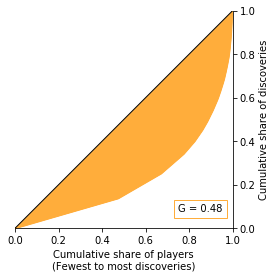

In [122]:
highlight_col = '#ffad3b'

# Cumulative distribution
ax = sns.lineplot(data = discoverers, x = 'cum_players', y = 'cum_discoveries', color = highlight_col)

# Fill in area over Lorenz curve
ax.fill_between(discoverers['cum_players'], discoverers['cum_discoveries'], discoverers['cum_players'],
               color = highlight_col)

# Write Gini coefficient on plot
g = gini(discoverers['cum_discoveries'].values)
ax.text(0.75, 0.075, 'G = %.2f' % g, 
        bbox = {'facecolor': '#ffffff', 'edgecolor': highlight_col})

# Line of equality
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='-', color='black', linewidth = 1) 
## Customize
ax.yaxis.tick_right() # Move axes to the right
ax.yaxis.set_label_position("right")
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.set(xlim = [0,1], ylim= [0,1], aspect = 1.0,
       xlabel='Cumulative share of players\n(Fewest to most discoveries)',
       ylabel='Cumulative share of discoveries')